# 导入库

In [16]:
import meshio
import numpy as np
import matplotlib.pyplot as plt
from cmath import *
%matplotlib inline

# 读取网格信息

In [17]:
mesh = meshio.read("waveguide_plane.msh", file_format = ("gmsh"))

# 节点坐标提取
nodes = mesh.points
Nn = nodes.shape[0]
x = nodes[:, 0]; y = nodes[:, 1]

# 物理组件编号提取
phy_line = mesh.cell_data_dict["gmsh:physical"]["line"]
phy_triangle = mesh.cell_data_dict["gmsh:physical"]["triangle"]

# 单元编码提取
ele_line = mesh.cells_dict["line"]
ele_triangle = mesh.cells_dict["triangle"]

# ele_filter 为单元筛选函数
def ele_filter(ele_data, phy_data, num_phy):
    num = np.where(phy_data == num_phy)
    count = len(num[0])
    elements = ele_data[num[0], :].T
    return (count, elements)

# 刚度矩阵计算

In [18]:
# stiffness_matrix  函数用于刚度矩阵方程的计算
def stiffness_matrix(Ne, n, K, B, alphax, alphay, beta, f):
    Ke = np.zeros((3, 3), dtype = complex)
    Be = np.zeros((3), dtype = complex)
    be = np.zeros((3), dtype = float)
    ce = np.zeros((3), dtype = float)
    
    for e in range(0, Ne):
        be[0] = y[n[1, e]]-y[n[2, e]]
        be[1] = y[n[2, e]]-y[n[0, e]]
        be[2] = y[n[0, e]]-y[n[1, e]]
        ce[0] = x[n[2, e]]-x[n[1, e]]
        ce[1] = x[n[0, e]]-x[n[2, e]]
        ce[2] = x[n[1, e]]-x[n[0, e]]
        # 三角单元面积
        Deltae = abs((be[0]*ce[1]-be[1]*ce[0]))/2.
        
        # 单元刚度矩阵计算
        for i in range(0, 3):
            for j in range(0, 3):
                if (i == j):
                    delta_ij = 1
                else:
                    delta_ij = 0
                Ke[i][j] = (alphax*be[i]*be[j]+alphay*ce[i]*ce[j])/(4.*Deltae)\
                        +Deltae*beta*(1+delta_ij)/12.
            Be[i] = Deltae*f/3.
        # 单元刚度矩阵组合至总刚度矩阵
        for i in range(0, 3):
            for j in range(0, 3):
                K[n[i][e]][n[j][e]] = K[n[i][e]][n[j][e]]+Ke[i][j]
            B[n[i][e]] = B[n[i][e]]+Be[i]
    return (K, B)

# Robin 边界条件处理

In [19]:
# Robin_boundary 函数用于处理 Robin 边界条件 
def Robin_boundary(Ns, ns, K, B, gamma, q):
    Ks = np.zeros((2, 2), dtype = complex)

    for s in range(0, Ns):
        i = ns[0][s]
        j = ns[1][s]
        # 线段单元长度
        ls = sqrt((x[i]-x[j])**2+(y[i]-y[j])**2)

        # 单元刚度矩阵元素
        Ks[0][0] = gamma*ls/3
        Ks[0][1] = gamma*ls/6
        Ks[1][0] = Ks[0][1]
        Ks[1][1] = Ks[0][0]
        
        # 单元刚度矩阵组合至总刚度矩阵
        for i in range(0, 2):
            for j in range(0, 2):
                K[ns[i][s]][ns[j][s]] = K[ns[i][s]][ns[j][s]]+Ks[i][j]
            B[ns[i][s]] = B[ns[i][s]]+q*ls/2
    return (K, B)

## 频带设置

In [20]:
lambda0 = np.arange(0.1, 10, 0.2)
k = 2*pi/lambda0

# 有限元计算

In [21]:
R_FEM = []
T_FEM = []
for k0 in k:
    # 刚度矩阵初始化
    K = np.zeros((Nn, Nn), dtype = complex)
    b = np.zeros((Nn), dtype = complex)
    # 空气处刚度矩阵方程计算
    (Ne, n) = ele_filter(ele_triangle, phy_triangle, 14)
    epsilon0 = 1; mur0 = 1; f = 0
    alphax = 1/epsilon0; alphay = 1/epsilon0; beta = -k0**2*mur0
    (K, b) = stiffness_matrix(Ne, n, K, b, alphax, alphay, beta, f)
    # 介质处刚度矩阵方程计算
    (Ne, n) = ele_filter(ele_triangle, phy_triangle, 15)
    epsilon1 = 2+0*1j; mur0 = 1; f = 0
    alphax = 1/epsilon1; alphay = 1/epsilon1; beta = -k0**2*mur0
    (K, b) = stiffness_matrix(Ne, n, K, b, alphax, alphay, beta, f)
    # 波导壁边界条件处理
    (Ns, ns) = ele_filter(ele_line, phy_line, 11)
    gamma = 0; q = 0
    (K, b) = Robin_boundary(Ns, ns, K, b, gamma, q)
    # 入射口处边界条件
    (Ns, ns) = ele_filter(ele_line, phy_line, 12)
    epsilon0 = 1; H0 = 2
    alphax = 1/epsilon0; gamma = 1j*alphax*k0; q = 2*1j*alphax*k0*H0*exp(-1j*k0*0)
    (K, b) = Robin_boundary(Ns, ns, K, b, gamma, q)
    # 出射口处边界条件
    (Ns, ns) = ele_filter(ele_line, phy_line, 13)
    epsilon0 = 1
    alphax = 1/epsilon0; gamma = alphax*1j*k0; q = 0
    (K, b) = Robin_boundary(Ns, ns, K, b, gamma, q)
    # 刚度矩阵求解
    Hz = np.linalg.solve(K, b)
    # 反射系数与透射系数
    R = (Hz[106]-H0*exp(-1j*k0*x[106]))/(H0*exp(-1j*k0*x[106]))
    T = Hz[135]/(H0*exp(-1j*k0*x[135]))
    R_FEM.append(abs(R))
    T_FEM.append(abs(T))

# 反射系数解析解计算

$$
\begin{aligned}
    &R=\frac{R_{01}+R_{1t}\exp(i2k_{1y}d)}{1+R_{1t}R_{01}\exp(i2k_1yd)}\\
    &p_{01}=\frac{\varepsilon_0k_1}{\varepsilon_1k_0}\hspace{5ex}p_{1t}=\frac{\varepsilon_1k_0}{\varepsilon_0k_1}\\
    &R_{1t}=\frac{1-p_{1t}}{1+p_{1t}}\hspace{5ex}R_{01}=\frac{1-p_{01}}{1+p_{01}}
\end{aligned}
$$

In [22]:
# 此函数用于计算反射系数
def analytic(epsilon0, epsilon1, d, k0):
    k1 = k0*sqrt(epsilon1)/sqrt(epsilon0)
    p01 = (epsilon0*k1)/(epsilon1*k0)
    p1t = (epsilon1*k0)/(epsilon0*k1)
    R01 = (1-p01)/(1+p01)
    R1t = (1-p1t)/(1+p1t)

    R = (R01+R1t*exp(1j*2*k1*d))/(1+R1t*R01*exp(1j*2*k1*d))

    return R

In [23]:
# 解析解计算反射系数
lambda1 = np.arange(0.1, 10, 0.1)
k = 2*pi/lambda1
R_ana = []
for k0 in k:
    R_ana.append(abs(analytic(epsilon0, epsilon1, 0.5, k0)))

# 结果可视化

Text(0.5, 1.0, 'Comparative of media reflection coefficient')

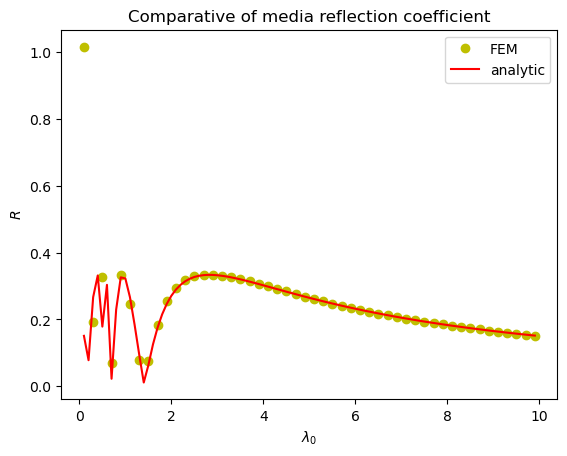

In [24]:
R_FEM = np.array(R_FEM)
R_ana = np.array(R_ana)

fig, ax = plt.subplots()
fem = ax.plot(lambda0, R_FEM, 'yo', label = 'FEM')
ana = ax.plot(lambda1, R_ana, 'r-', label = 'analytic')
plt.legend()
plt.xlabel(r'$\lambda_0$')
plt.ylabel(r'$R$')
plt.title('Comparative of media reflection coefficient')